## Purpose: This notebook is used to address the question "What factors have the strongest correlation with the happiness ranking". Various approaches using scatterplots, correlations cooeficients, and various other visualizations in order to derive the answer to that question.

## Environment Setup:
A yaml file is provided to create a conda environment to run this notebook.
To create the env run the following command: conda env create -f ./data/env/environment.yml

### In order to gain more context regarding the diversity of the data set we will show the countries that the data pretains to and their respecitve happiness scores. A visualization approach called a choropleth map will be generated to show this information. 

In [78]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import pycountry
import seaborn as sns
import matplotlib.pyplot as plt

### Read in the happiness data using pandas

In [20]:
df = pd.read_csv('./data/data_all.csv')
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year,Lower Confidence Interval,Upper Confidence Interval,Whisker.high,Whisker.low
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015,NaN,NaN,NaN,NaN
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015,NaN,NaN,NaN,NaN
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015,NaN,NaN,NaN,NaN
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015,NaN,NaN,NaN,NaN
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015,NaN,NaN,NaN,NaN


### Validate the data types of our variables of interest

In [21]:
df.dtypes

Country                           object
Region                            object
Happiness Rank                     int64
Happiness Score                  float64
Standard Error                   float64
Economy (GDP per Capita)         float64
Family                           float64
Health (Life Expectancy)         float64
Freedom                          float64
Trust (Government Corruption)    float64
Generosity                       float64
Dystopia Residual                float64
Year                               int64
Lower Confidence Interval        float64
Upper Confidence Interval        float64
Whisker.high                     float64
Whisker.low                      float64
dtype: object

### Obtain Country Codes. This will be used to associated the data with another dataframe that contains the geometries of the countries for plotting pruposes.

In [23]:
input_countries = df['Country']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

codes = [countries.get(country, np.nan) for country in input_countries]

df['Country Code'] = codes
df.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year,Lower Confidence Interval,Upper Confidence Interval,Whisker.high,Whisker.low,Country Code
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015,NaN,NaN,NaN,NaN,CHE
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015,NaN,NaN,NaN,NaN,ISL
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015,NaN,NaN,NaN,NaN,DNK
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015,NaN,NaN,NaN,NaN,NOR
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015,NaN,NaN,NaN,NaN,CAN


### Read in the country level shapefiles to obtain geometries

In [28]:
shapefile = r'C:\Users\mkbau\OneDrive\Documents\GitHub\ds5100-group2\data\ne_10m_admin_0_countries\ne_10m_admin_0_countries.shp'
gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('EPSG:4326')
print(len(gdf))
gdf.head()

258


,ADM0_A3,geometry
0,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,MYS,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,CHL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,BOL,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,PER,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


### Validate the data types. Note we want to ensure the geoemtry column is in fact a geometry for plotting purposes

In [10]:
gdf.dtypes

ADM0_A3       object
geometry    geometry
dtype: object

### In order to further valdate the data we an create a script to run a unittest to compare the data type of the geometry field 

In [25]:
%%writefile unittests.py

import os
import unittest
import geopandas as gpd

class GDFTest(unittest.TestCase):
   
    def test_for_geometry(self):
        """
        Unit test to check if geopandas dataframe geometry 
        column is in fact a geometry type.

        Returns
        -------
        None.

        """
        fp = os.path.join(os.path.dirname(__file__), r'data\ne_10m_admin_0_countries\ne_10m_admin_0_countries.shp')
        test_gdf = gpd.read_file(fp)[['geometry']].to_crs('EPSG:4326')
        sample_gdf = gpd.GeoDataFrame({'geometry': []}, crs="EPSG:4326")
        self.assertEqual(test_gdf['geometry'].dtype, sample_gdf['geometry'].dtype)
        
if __name__ == '__main__':
    unittest.main()

Overwriting unittests.py


In [27]:
!python unittests.py

.
----------------------------------------------------------------------
Ran 1 test in 0.202s

OK


### Merge the Happiness data and the country shapefile using the appropriate keys to from each dataframe

In [11]:
merged = gdf.merge(df, left_on='ADM0_A3', right_on='Country Code', how='left')
print(len(merged))
merged.head()

793


,ADM0_A3,geometry,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year,Lower Confidence Interval,Upper Confidence Interval,Whisker.high,Whisker.low,Country Code
0,IDN,"MULTIPOLYGON (((11108970.260 445285.130, 11108...",Indonesia,Southeastern Asia,74.0,5.399,0.02596,0.828270,1.087080,0.637930,0.466110,0.000000,0.515350,1.863990,2015.0,NaN,NaN,NaN,NaN,IDN
1,IDN,"MULTIPOLYGON (((11108970.260 445285.130, 11108...",Indonesia,Southeastern Asia,79.0,5.314,NaN,0.951040,0.876250,0.493740,0.392370,0.003220,0.565210,2.031710,2016.0,5.237,5.391,NaN,NaN,IDN
2,IDN,"MULTIPOLYGON (((11108970.260 445285.130, 11108...",Indonesia,NaN,81.0,5.262,NaN,0.995539,1.274445,0.492346,0.443323,0.015317,0.611705,1.429477,2017.0,NaN,NaN,5.352889,5.171112,IDN
3,IDN,"MULTIPOLYGON (((11108970.260 445285.130, 11108...",Indonesia,NaN,96.0,5.093,NaN,0.899000,1.215000,0.522000,0.538000,0.018000,0.484000,NaN,2018.0,NaN,NaN,NaN,NaN,IDN
4,IDN,"MULTIPOLYGON (((11108970.260 445285.130, 11108...",Indonesia,NaN,92.0,5.192,NaN,0.931000,1.203000,0.660000,0.491000,0.028000,0.498000,NaN,2019.0,NaN,NaN,NaN,NaN,IDN


### Since we have multiple years for the happiness data we will aggregate the data. The grouping will be based on the country column and we will get the mean. For spatial data, we will need to use the dissolve function to aggregate geometric features.

In [34]:
merged_grouped = merged.dissolve(by = 'ADM0_A3', aggfunc='mean', as_index=False)

### Validate the geometry field type was conserved after the dissolve was performed

In [13]:
merged_grouped.dtypes

ADM0_A3                            object
geometry                         geometry
Happiness Rank                    float64
Happiness Score                   float64
Standard Error                    float64
Economy (GDP per Capita)          float64
Family                            float64
Health (Life Expectancy)          float64
Freedom                           float64
Trust (Government Corruption)     float64
Generosity                        float64
Dystopia Residual                 float64
Year                              float64
Lower Confidence Interval         float64
Upper Confidence Interval         float64
Whisker.high                      float64
Whisker.low                       float64
dtype: object

### In some cases one can see that we do not have the Happiness Score for some countries. We will leave the NaN value and custumize the visualization to show where that missing data is.

In [15]:
merged_grouped[['Happiness Score', 'geometry', 'ADM0_A3']].head()

,Happiness Score,geometry,ADM0_A3
0,NaN,"POLYGON ((-6566421.832 1345196.571, -6561069.0...",ABW
1,3.51280,"POLYGON ((6583438.231 3957831.660, 6583549.343...",AFG
2,3.87225,"MULTIPOLYGON (((1095193.915 -1786718.053, 1093...",AGO
3,NaN,"MULTIPOLYGON (((-5860540.976 1954636.075, -586...",AIA
4,4.71260,"POLYGON ((1771105.214 4472068.357, 1771131.811...",ALB


### Create the choropleth map

In [16]:
colors = 9
cmap = 'Oranges'
figsize = (16, 10)
val = 'Happiness Score'
title = '{}'.format(val)
description = ''''''.strip()

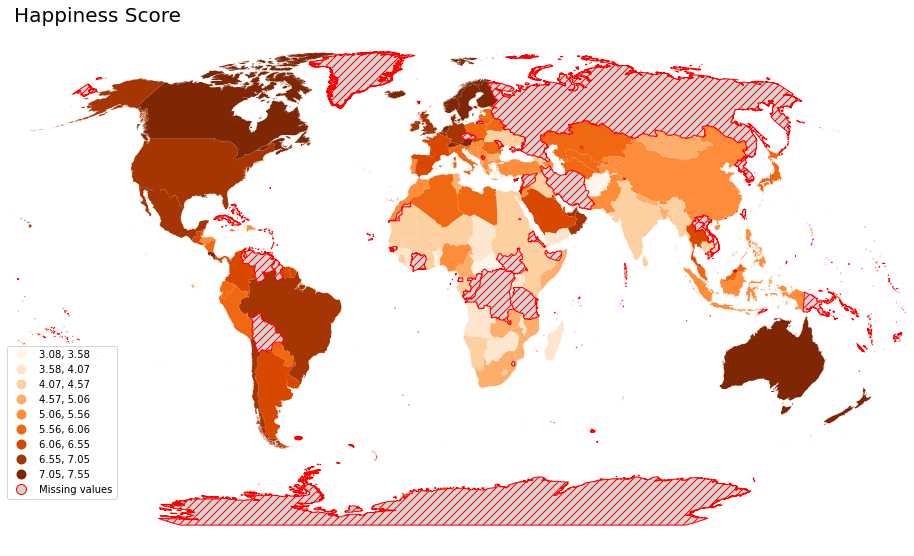

In [17]:
ax = merged_grouped.plot(column=val, 
                 cmap=cmap, 
                 figsize=figsize, 
                 scheme='equal_interval', 
                 k=colors, 
                 legend=True,
                 missing_kwds={
                    "color": "lightgrey",
                    "edgecolor": "red",
                    "hatch": "///",
                    "label": "Missing values"})

ax.set_title(title, fontdict={'fontsize': 20}, loc='left')
ax.annotate(description, xy=(0.1, 0.1), size=12, xycoords='figure fraction')

ax.set_axis_off()
ax.set_xlim([-1.5e7, 1.7e7])
ax.get_legend().set_bbox_to_anchor((.12, .4))

### In conclusion we can now reference this map to quickly note which countries are and are not contained on the data, which is useful for quickly resolving any missing data or faciliating discussion about the data. One can conlude there is fair global coverage showing little biase in the collected data

### Next we will look more at the data in greater detail to determine what factors amoungst there nations have the strongest correlation to the happiness score. We will built off of the merged_grouped dataframe.

In [35]:
merged_grouped.head()

,ADM0_A3,geometry,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year,Lower Confidence Interval,Upper Confidence Interval,Whisker.high,Whisker.low
0,ABW,"POLYGON ((-6566421.832 1345196.571, -6561069.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,"POLYGON ((6583438.231 3957831.660, 6583549.343...",149.4,3.51280,0.03084,0.357113,0.409753,0.254707,0.117924,0.058094,0.267730,2.082827,2017.0,3.288,3.432,3.873661,3.714338
2,AGO,"MULTIPOLYGON (((1095193.915 -1786718.053, 1093...",140.0,3.87225,0.04758,0.798380,0.938368,0.133902,0.027433,0.071570,0.105269,1.886154,2016.5,3.753,3.979,3.951642,3.638358
3,AIA,"MULTIPOLYGON (((-5860540.976 1954636.075, -586...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,"POLYGON ((1771105.214 4472068.357, 1771131.811...",106.4,4.71260,0.05013,0.938633,0.754931,0.787696,0.371898,0.043201,0.167887,1.772514,2017.0,4.546,4.764,4.752464,4.535536


### We need to consider that there are NA values in the dataframe so lets drop those to continue this analysis. 

In [60]:
merged_grouped_clean = merged_grouped.dropna()
merged_grouped_clean.head()

,ADM0_A3,geometry,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year,Lower Confidence Interval,Upper Confidence Interval,Whisker.high,Whisker.low
1,AFG,"POLYGON ((6583438.231 3957831.660, 6583549.343...",149.4,3.51280,0.03084,0.357113,0.409753,0.254707,0.117924,0.058094,0.267730,2.082827,2017.0,3.288,3.432,3.873661,3.714338
2,AGO,"MULTIPOLYGON (((1095193.915 -1786718.053, 1093...",140.0,3.87225,0.04758,0.798380,0.938368,0.133902,0.027433,0.071570,0.105269,1.886154,2016.5,3.753,3.979,3.951642,3.638358
4,ALB,"POLYGON ((1771105.214 4472068.357, 1771131.811...",106.4,4.71260,0.05013,0.938633,0.754931,0.787696,0.371898,0.043201,0.167887,1.772514,2017.0,4.546,4.764,4.752464,4.535536
7,ARE,"MULTIPOLYGON (((4940765.382 2587450.072, 49408...",22.0,6.74420,0.03729,1.645227,1.069860,0.752196,0.538813,0.311982,0.267826,2.065735,2017.0,6.494,6.652,6.722047,6.573952
8,ARG,"MULTIPOLYGON (((-5418854.742 -5822336.166, -54...",31.2,6.45940,0.04612,1.111035,1.330960,0.760895,0.481620,0.064308,0.092371,2.859952,2017.0,6.560,6.740,6.690085,6.507915


### We will also consider a subset of the features in this analysis as well.

In [61]:
features = ["Happiness Rank", 
            "Happiness Score", 
            "Standard Error", 
            "Economy (GDP per Capita)", 
            "Family",
            "Health (Life Expectancy)", 
            "Freedom",
            "Trust (Government Corruption)", 
            "Generosity", 
            "Dystopia Residual"]
merged_grouped_clean = merged_grouped_clean[features]
merged_grouped_clean.head()

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
1,149.4,3.51280,0.03084,0.357113,0.409753,0.254707,0.117924,0.058094,0.267730,2.082827
2,140.0,3.87225,0.04758,0.798380,0.938368,0.133902,0.027433,0.071570,0.105269,1.886154
4,106.4,4.71260,0.05013,0.938633,0.754931,0.787696,0.371898,0.043201,0.167887,1.772514
7,22.0,6.74420,0.03729,1.645227,1.069860,0.752196,0.538813,0.311982,0.267826,2.065735
8,31.2,6.45940,0.04612,1.111035,1.330960,0.760895,0.481620,0.064308,0.092371,2.859952


### Let's start by getting the correlation coefficients to contextually assess the correlation. We can easily find highly correlated values by adding a color map to the matrix

In [91]:
corr = merged_grouped_clean.corr().style.background_gradient(cmap='coolwarm')
corr

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Happiness Rank,1.000000,-0.994681,0.171209,-0.830755,-0.772557,-0.809983,-0.603056,-0.462227,-0.198228,-0.517818
Happiness Score,-0.994681,1.000000,-0.200267,0.828238,0.776212,0.808089,0.613829,0.488822,0.227536,0.513775
Standard Error,0.171209,-0.200267,1.000000,-0.199192,-0.137346,-0.228986,-0.162859,-0.307123,-0.093868,0.006648
Economy (GDP per Capita),-0.830755,0.828238,-0.199192,1.000000,0.724381,0.831846,0.419137,0.397600,0.011405,0.122107
Family,-0.772557,0.776212,-0.137346,0.724381,1.000000,0.660673,0.479167,0.284351,0.153792,0.118561
Health (Life Expectancy),-0.809983,0.808089,-0.228986,0.831846,0.660673,1.000000,0.447207,0.349222,0.063194,0.175175
Freedom,-0.603056,0.613829,-0.162859,0.419137,0.479167,0.447207,1.000000,0.509804,0.412893,0.094886
Trust (Government Corruption),-0.462227,0.488822,-0.307123,0.397600,0.284351,0.349222,0.509804,1.000000,0.296457,0.049393
Generosity,-0.198228,0.227536,-0.093868,0.011405,0.153792,0.063194,0.412893,0.296457,1.000000,-0.034683
Dystopia Residual,-0.517818,0.513775,0.006648,0.122107,0.118561,0.175175,0.094886,0.049393,-0.034683,1.000000


### We can see that Econ, Family, and Health are strongly correlated to the happiness score. addtionally, one can see that there is in fact a strong correlation between family, health, and econ 

### Now that we have an idea of the most stronly correlated values let's do a scatter plot to validate|

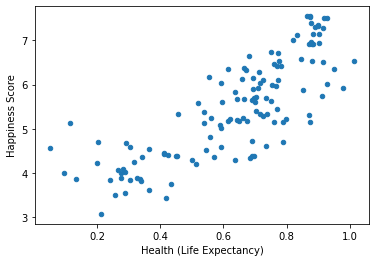

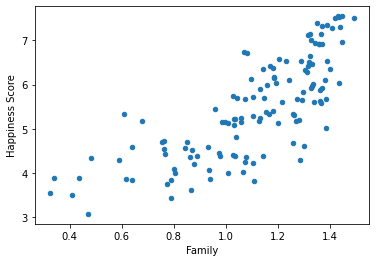

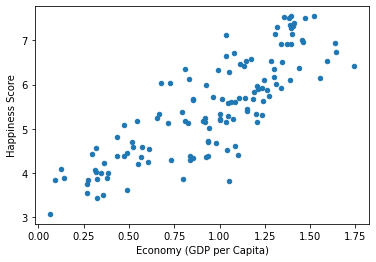

In [88]:
correlated = ['Health (Life Expectancy)', 'Family', 'Economy (GDP per Capita)']
for c in correlated:
    ax = merged_grouped_clean.plot.scatter(x=c, y="Happiness Score")

### Now that we have an more intution of what variables are strongly correlated to the happiness score we can more effciently create a model with the selected features.

In [95]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [121]:
df =  merged_grouped_clean

In [120]:
pred = ['Health (Life Expectancy)', 'Family', 'Economy (GDP per Capita)']
resp = ['Happiness Score']

In [122]:
keep_cols = pred + resp
df = df[keep_cols]
df = df.dropna()
df.head()

,Health (Life Expectancy),Family,Economy (GDP per Capita),Happiness Score
1,0.254707,0.409753,0.357113,3.51280
2,0.133902,0.938368,0.798380,3.87225
4,0.787696,0.754931,0.938633,4.71260
7,0.752196,1.069860,1.645227,6.74420
8,0.760895,1.330960,1.111035,6.45940


In [123]:
X = df[pred]
y = df[resp]

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [125]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [126]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [127]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(103, 3) (103,)
(26, 3) (26,)


In [146]:
n_estimators = [100, 200, 500, 1000]
mae, mse, rmse, train_scores, test_scores = [], [], [], [], []

for n in n_estimators:
    
    regressor = RandomForestRegressor(n_estimators=n, random_state=0)
    # regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    
    train_scores.append(regressor.score(X_train, y_train))
    test_scores.append(regressor.score(X_test, y_test))

    test_y_pred = regressor.predict(X_test)
    mae.append(metrics.mean_absolute_error(y_test, test_y_pred))
    mse.append(metrics.mean_squared_error(y_test, test_y_pred))
    rmse.append(np.sqrt(metrics.mean_squared_error(y_test, test_y_pred)))

In [147]:
metrics_df = pd.DataFrame({
    'n_estimators': n_estimators,
    'mean_absolute_error': mae,
    'mean_squared_error': mse,
    'root_mean_squared_error': rmse,
    'train_scores': train_scores,
    'test_scores': test_scores
})

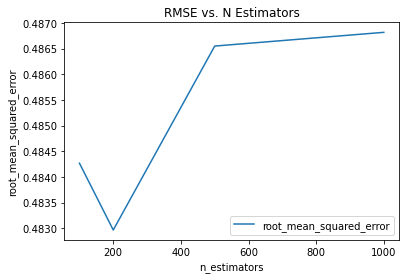

In [148]:
metrics_df.plot(    
    x='n_estimators', 
    y='root_mean_squared_error',
    kind='line',
    title='RMSE vs. N Estimators',    
    xlabel='n_estimators', 
    ylabel='root_mean_squared_error', 
)

plt.show()

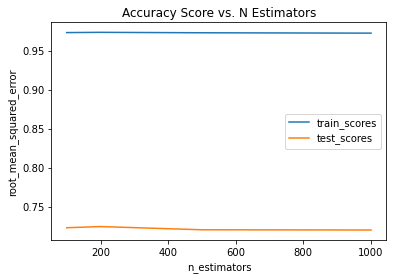

In [149]:
metrics_df.plot(    
    x='n_estimators', 
    y=['train_scores', 'test_scores'],
    kind='line',
    legend=True,
    title='Accuracy Score vs. N Estimators',    
    xlabel='n_estimators', 
    ylabel='root_mean_squared_error'
)

plt.show()

In [150]:
econ_new = [.5]
trust_new = [.5]
freed_new = [.5]
gen_new = [.5] 

Xnew = pd.DataFrame({'Health (Life Expectancy)': trust_new, 
                     'Family': freed_new,
                     'Economy (GDP per Capita)': econ_new, })
Xnew = sc.transform(Xnew)
# make a prediction
ynew = regressor.predict(Xnew)
# show the inputs and predicted outputs
for i in range(len(Xnew)):
    print(f"X = {Xnew[i]}, Predicted = {ynew[i]}")

X = [-0.48556194 -2.1926341  -1.04989189], Predicted = 4.176589397761902
